In [269]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log, exp
from bsm_math import bsm_value, bsm_vega

In [270]:
def normal_sample(N, k=1, random_state=None):
    np.random.seed(random_state)
    return np.random.normal(0, 1, size=(k, N))

def brownian_motion(T, N, k=1, random_state=None):
    dW = normal_sample(N, k) * sqrt (T / N)
    return np.insert(dW.cumsum(axis=1), 0, 0, 1)

def GBM(T, N, mu, sigma, S_0, k=1, random_state=None):
    time = np.linspace(0, T, N+1)
    W = brownian_motion(T, N, k)
    S = S_0 * np.exp((mu - (sigma ** 2) / 2) * time + sigma * W)
    return (S)

In [339]:
def bsm_value_vector(S, K, T, r, q, sigma, Flag):
    from math import sqrt, exp
    from scipy import stats

    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (np.log(S/K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    if Flag == 0:
        value = (S * exp(-q * T) * stats.norm.cdf(d1, 0.0, 1.0) -
                 K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    elif Flag == 1:
        value = (K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) -
                 S * exp(-q * T) * stats.norm.cdf(-d1, 0.0, 1.0))
    else:
        value = 'NaN'
    return value

def bsm_delta_vector(S, K, T, r, q, sigma, Flag):
    from math import log, sqrt, exp
    from scipy import stats
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    if Flag == 0:
        delta = exp(-q * T) * stats.norm.cdf(d1, 0.0, 1.0)
    elif Flag == 1:
        delta = exp(-q * T) * (stats.norm.cdf(d1, 0.0, 1.0) - 1)
    else:
        delta = 'NaN'
    return delta

def bsm_gamma_vector(S, K, T, r, q, sigma):
    from math import log, sqrt, exp
    from scipy import stats
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return (stats.norm.pdf(d1, 0, 1) * exp(-q * T) / (S * sigma * np.sqrt(T)))

def vanilla_dh(paths, K, T, r, q, val_vol, hedging_vol, Flag):
    (n, N) = paths.shape
    maturities = np.linspace(T, 0, n)
    deltas = np.zeros([n, N])
    values = np.zeros([n, N])
    gammas = np.zeros([n, N])
    with np.errstate(divide='ignore',invalid='ignore'):
        for i, m in enumerate(maturities): 
            values[i] = bsm_value_vector(sample[i], K, m, r, q, val_vol, Flag)
            deltas[i] = bsm_delta_vector(sample[i], K, m, r, q, hedging_vol, Flag)
            gammas[i] = bsm_gamma_vector(sample[i], K, m, r, q, hedging_vol)
    trading = np.zeros([n, N])
    trading[0] = deltas[0] * sample[0] - values[0]
    for i in range(1,n):
        trading[i] = sample[i]  * (deltas[i] - deltas[i-1])
    exercise = - K * deltas[-1]
    trading[-1] = trading[-1] + exercise
    return trading, values, deltas, gammas

In [340]:
T = 1
n_hedges = 260
r = 0
q = 0
vol = 0.3
K = 100
N = 50000
implied = 0.3

In [350]:
sample = GBM(T, n_hedges, r-q, vol, K, N).T

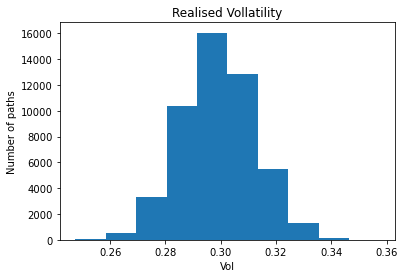

Average realised volatility: 0.2991, Standard deviation of realised volatility: 0.0132


In [416]:
realised_vol = (np.log(sample[:-1,]) - np.log(sample[1:,])).std(axis=0) * sqrt(n_hedges/T)
plt.hist((realised_vol))
plt.title("Realised Vollatility")
plt.ylabel("Number of paths")
plt.xlabel('Vol')
plt.show()
print("Average realised volatility: %.4f, Standard deviation of realised volatility: %.4f" %
      (realised_vol.mean(), realised_vol.std()))

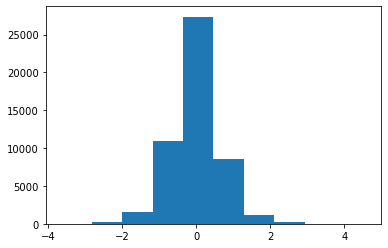

Delta hedging average PL: 0.0019, Delta hedging PL standard deviation: 0.6496


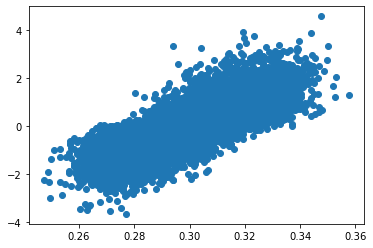

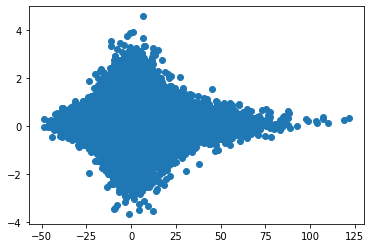

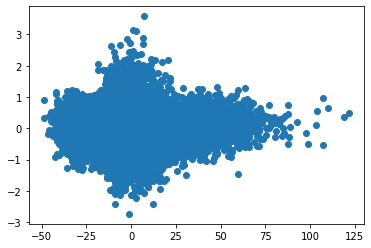

In [364]:
trading, values, deltas, gammas  = vanilla_dh(sample, K, T, r, q, implied, implied, 0)
dh_pl = (trading).cumsum(axis=0)[-1]
plt.hist(dh_pl)
plt.show()
print("Delta hedging average PL: %.4f, Delta hedging PL standard deviation: %.4f" %
      (dh_pl.mean(), dh_pl.std()))
plt.scatter(realised_vol, dh_pl)
plt.show()
mean_dist = (sample.mean(axis=0) - K)
plt.scatter(mean_dist, dh_pl)
plt.show()
vega_pl = (realised_vol - vol) * bsm_vega(K, K, T, r, q, vol)
plt.scatter(mean_dist, dh_pl - vega_pl)
plt.show()

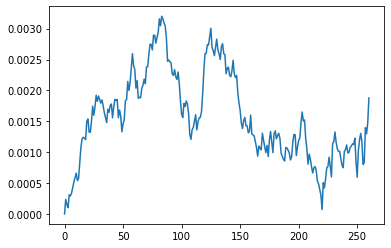

In [413]:
values[-1] = 0
deltas[-1] = 0
plt.plot((trading.cumsum(axis=0) + values - deltas * sample).mean(axis=1))

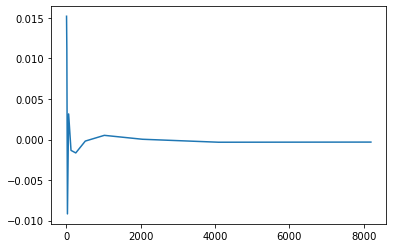

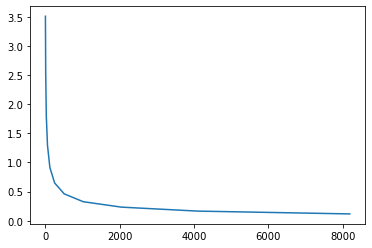

In [349]:
dh_stdev = []
dh_mean = []
freq = 2 ** np.linspace(3, 13, 11)
for i in freq:
    sample = GBM(T, int(i), r-q, vol, K, N).T
    trading = (vanilla_dh(sample, K, T, r, q, implied, implied, 0)[0])
    dh_stdev.append(trading.sum(axis=0).std())
    dh_mean.append(trading.sum(axis=0).mean())
plt.plot(freq, dh_mean)
plt.show()
plt.plot(freq, dh_stdev)
plt.show()

In [361]:
gammas[:-1].mean(axis=0)

(50000,)

In [280]:
maturities = np.linspace(T, 0, days+1)
deltas = np.zeros([days+1, N])
values = np.zeros([days+1, N])
gammas = np.zeros([days+1, N])
implied = 0.3 
with np.errstate(divide='ignore',invalid='ignore'):
    for i, m in enumerate(maturities): 
        values[i] = bsm_value_vector(sample[i], K, m, r, q, implied, 0)
        deltas[i] = bsm_delta_vector(sample[i], K, m, r, q, implied, 0)
        gammas[i] = bsm_gamma_vector(sample[i], K, m, r, q, implied)

In [281]:
trading = np.zeros([days+1, N])
trading[0] = deltas[0] * sample[0]
for i in range(1,days+1):
    trading[i] = sample[i]  * (deltas[i] - deltas[i-1])
exercise = - K * deltas[-1]
trading[-1] = trading[-1] + exercise

In [299]:
def vanilla_dh(paths, K, T, r, q, implied, Flag):
    (n, N) = paths.shape
    maturities = np.linspace(T, 0, n)
    deltas = np.zeros([n, N])
    values = np.zeros([n, N])
    gammas = np.zeros([n, N])
    with np.errstate(divide='ignore',invalid='ignore'):
        for i, m in enumerate(maturities): 
            values[i] = bsm_value_vector(sample[i], K, m, r, q, implied, Flag)
            deltas[i] = bsm_delta_vector(sample[i], K, m, r, q, implied, Flag)
            gammas[i] = bsm_gamma_vector(sample[i], K, m, r, q, implied)
    trading = np.zeros([n, N])
    trading[0] = deltas[0] * sample[0] - values[0]
    for i in range(1,n):
        trading[i] = sample[i]  * (deltas[i] - deltas[i-1])
    exercise = - K * deltas[-1]
    trading[-1] = trading[-1] + exercise
    return trading

In [302]:
vanilla_dh(sample, K, T, r, q, implied, 0).cumsum(axis=0)[-1]

array([-0.15499785, -0.10004141,  0.13953266, ..., -0.38185391,
       -1.26916727, -0.6330693 ])

In [303]:
bsm_value_vector(K, K, T, r, q, (np.log(sample[:-1,]) - np.log(sample[1:,])).std(axis=0) * sqrt(days/T), 0) - \
bsm_value(K, K, T, r, q, vol, 0)

array([-0.45744786, -0.33121624, -0.34201562, ..., -0.06876481,
       -0.51930029, -0.18339669])

In [282]:
print('Delta Hedging Strategy vs Theoretical valuation')
print(trading.cumsum(axis=0)[-1].mean(), bsm_value(K, K, T, r, q, vol, 0))

Delta Hedging Strategy vs Theoretical valuation
11.925795995962979 11.923538474048499


In [283]:
trading.cumsum(axis=0)[-1].std()

0.6470433988011196

In [225]:
deltas[1]

array([0.57521963, 0.4727654 , 0.57608257, ..., 0.50136717, 0.57628254,
       0.49549504])

In [244]:
vega_pl = ((np.log(sample[:-1,]) - np.log(sample[1:,])).std(axis=0) * sqrt(260) - 0.2) * bsm_vega(100,100,1,0,0,0.3)

In [245]:
pl = trading.cumsum(axis=0)[-1] - bsm_value(100,100,1,0,0,0.2, 0)

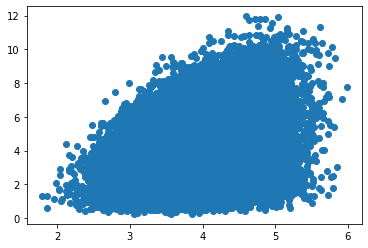

In [250]:
plt.scatter(vega_pl, pl)
plt.show()

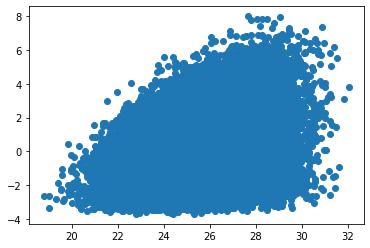

In [229]:
plt.scatter(vega_pl, pl)
plt.show()

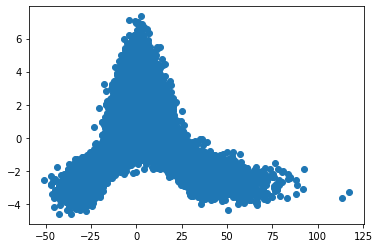

In [252]:
mean_dist = (sample.mean(axis=0)-100)
plt.scatter(mean_dist, pl - vega_pl)
plt.show()

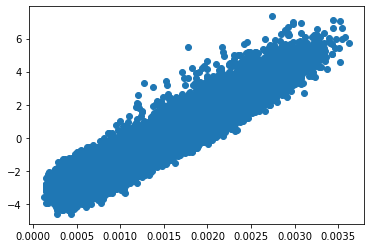

In [268]:
avg_gamma = ((((np.log(sample[:-1,]) - np.log(sample[1:,])) **2 ) * gammas[:-1])[:-1].sum(axis=0))
plt.scatter(avg_gamma, pl - vega_pl)
plt.show()

In [263]:
gammas[:-1].mean()

0.01613776485076639

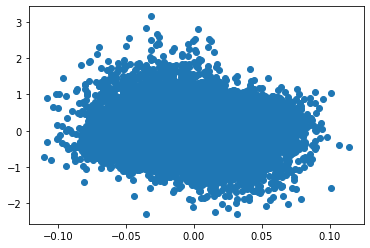

In [181]:
vol_dif = (np.log(sample[:129,]) - np.log(sample[1:130,])).std(axis=0) * sqrt(260)  -  \
(np.log(sample[130:-1,]) - np.log(sample[131:,])).std(axis=0) * sqrt(260)
plt.scatter(vol_dif, pl - vega_pl)
plt.show()

In [248]:
(pl - vega_pl).mean()

0.04712308168195071

In [249]:
(pl - vega_pl).std()

1.8484850744157004

In [236]:
pl.mean()

3.9598447886411163

In [247]:
vega_pl.mean()

3.9127217069591658

In [311]:
bsm_vega(100,100,1,0,0,0.3)

39.447933090788894